# Programming Exercise 8:
# Anomaly Detection and Recommender Systems


## Introduction 

In this exercise, you will implement the anomaly detection algorithm and
apply it to detect failing servers on a network. In the second part, you will
use collaborative filtering to build a recommender system for movies. Before
starting on the programming exercise, we strongly recommend watching the
video lectures and completing the review questions for the associated topics.

All the information you need for solving this assignment is in this notebook, and all the code you will be implementing will take place within this notebook. The assignment can be promptly submitted to the coursera grader directly from this notebook (code and instructions are included below).

Before we begin with the exercises, we need to import all libraries required for this programming exercise. Throughout the course, we will be using [`numpy`](http://www.numpy.org/) for all arrays and matrix operations, [`matplotlib`](https://matplotlib.org/) for plotting, and [`scipy`](https://docs.scipy.org/doc/scipy/reference/) for scientific and numerical computation functions and tools. You can find instructions on how to install required libraries in the README file in the [github repository](https://github.com/dibgerge/ml-coursera-python-assignments).

In [6]:
# used for manipulating directory paths
import os

# Scientific and vector computation for python
import numpy as np

# Plotting library
from matplotlib import pyplot
import matplotlib as mpl

# Optimization module in scipy
from scipy import optimize

# will be used to load MATLAB mat datafile format
from scipy.io import loadmat

# library written for this exercise providing additional functions for assignment submission, and others
import utils

# define the submission/grader object for this exercise
grader = utils.Grader()

# tells matplotlib to embed plots within the notebook
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (12, 9)

Populating the interactive namespace from numpy and matplotlib


## Submission and Grading


After completing each part of the assignment, be sure to submit your solutions to the grader. The following is a breakdown of how each part of this exercise is scored.


| Section | Part                                             | Submitted Function                | Points |
| :-      |:-                                                |:-                                 | :-:    |
| 1       | [Estimate Gaussian Parameters](#section1)        | [`estimateGaussian`](#estimateGaussian)      |  15    |
| 2       | [Select Threshold](#section2)                    | [`selectThreshold`](#selectThreshold)       |  15    |
| 3       | [Collaborative Filtering Cost](#section3)        | [`cofiCostFunc`](#cofiCostFunc)          |  20    |
| 4       | [Collaborative Filtering Gradient](#section4)    | [`cofiCostFunc`](#cofiCostFunc)          |  30    |
| 5       | [Regularized Cost](#section5)                    | [`cofiCostFunc`](#cofiCostFunc)          |  10    |
| 6       | [Gradient with regularization](#section6)        | [`cofiCostFunc`](#cofiCostFunc)          |  10    |
|         | Total Points                                     |                                   |100     |



You are allowed to submit your solutions multiple times, and we will take only the highest score into consideration.

<div class="alert alert-block alert-warning">
At the end of each section in this notebook, we have a cell which contains code for submitting the solutions thus far to the grader. Execute the cell to see your score up to the current section. For all your work to be submitted properly, you must execute those cells at least once.
</div>

## 1 Anomaly Detection 

In this exercise, you will implement an anomaly detection algorithm to detect anomalous behavior in server computers. The features measure the throughput (mb/s) and latency (ms) of response of each server. While your servers were operating, you collected $m = 307$ examples of how they were behaving, and thus have an unlabeled dataset $\{x^{(1)}, \dots, x^{(m)}\}$. You suspect that the vast majority of these examples are “normal” (non-anomalous) examples of the servers operating normally, but there might also be some examples of servers acting anomalously within this dataset.

You will use a Gaussian model to detect anomalous examples in your dataset. You will first start on a 2D dataset that will allow you to visualize what the algorithm is doing. On that dataset you will fit a Gaussian distribution and then find values that have very low probability and hence can be considered anomalies. After that, you will apply the anomaly detection algorithm to a larger dataset with many dimensions.

We start this exercise by using a small dataset that is easy to visualize. Our example case consists of 2 network server statistics across several machines: the latency and throughput of each machine. 

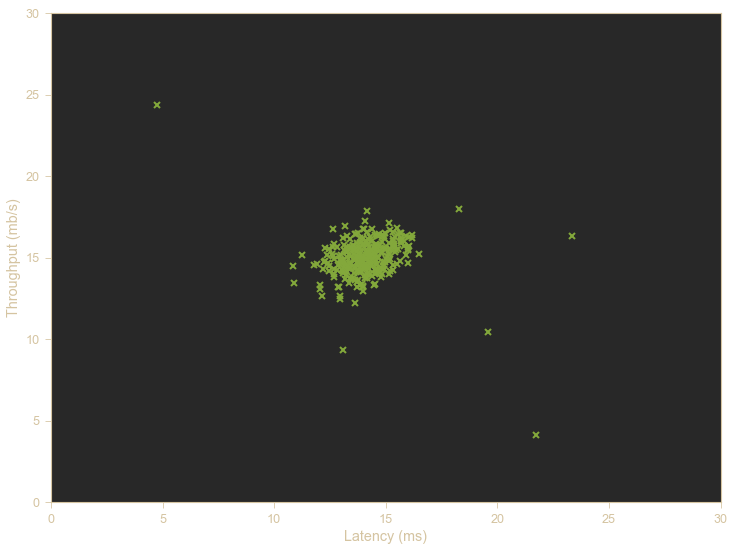

In [7]:
#  The following command loads the dataset.
data = loadmat(os.path.join('Data', 'ex8data1.mat'))
X, Xval, yval = data['X'], data['Xval'], data['yval'][:, 0]

#  Visualize the example dataset
pyplot.plot(X[:, 0], X[:, 1], 'bx', mew=2, mec='g', ms=6)
pyplot.axis([0, 30, 0, 30])
pyplot.xlabel('Latency (ms)')
pyplot.ylabel('Throughput (mb/s)')
pass

### 1.1 Gaussian distribution

To perform anomaly detection, you will first need to fit a model to the data's distribution. Given a training set $\{x^{(1)}, \dots, x^{(m)} \}$ (where $x^{(i)} \in \mathbb{R}^n$ ), you want to estimate the Gaussian distribution for each of the features $x_i$ . For each feature $i = 1 \dots n$, you need to find parameters $\mu_i$ and $\sigma_i^2$  that fit the data in the $i^{th}$ dimension $\{ x_i^{(1)}, \dots, x_i^{(m)} \}$ (the $i^{th}$ dimension of each example).

The Gaussian distribution is given by

$$ p\left( x; \mu, \sigma^2 \right) = \frac{1}{\sqrt{2\pi\sigma^2}} e^{-\frac{\left(x-\mu\right)^2}{2\sigma^2}},$$
where $\mu$ is the mean and $\sigma^2$ is the variance.

<a id="section1"></a>
### 1.2 Estimating parameters for a Gaussian 

You can estimate the parameters $\left( \mu_i, \sigma_i^2 \right)$, of the $i^{th}$ feature by using the following equations. To estimate the mean, you will use: 

$$ \mu_i = \frac{1}{m} \sum_{j=1}^m x_i^{(j)},$$

and for the variance you will use:

$$ \sigma_i^2 = \frac{1}{m} \sum_{j=1}^m \left( x_i^{(j)} - \mu_i \right)^2.$$

Your task is to complete the code in the function `estimateGaussian`. This function takes as input the data matrix `X` and should output an n-dimension vector `mu` that holds the mean for each of the $n$ features and another n-dimension vector `sigma2` that holds the variances of each of the features. You can implement this
using a for-loop over every feature and every training example (though a vectorized implementation might be more efficient; feel free to use a vectorized implementation if you prefer). 
<a id="estimateGaussian"></a>

In [21]:
def estimateGaussian(X):
    """
    This function estimates the parameters of a Gaussian distribution
    using a provided dataset.
    
    Parameters
    ----------
    X : array_like
        The dataset of shape (m x n) with each n-dimensional 
        data point in one row, and each total of m data points.
    
    Returns
    -------
    mu : array_like 
        A vector of shape (n,) containing the means of each dimension.
    
    sigma2 : array_like
        A vector of shape (n,) containing the computed
        variances of each dimension.
    
    Instructions
    ------------
    Compute the mean of the data and the variances
    In particular, mu[i] should contain the mean of
    the data for the i-th feature and sigma2[i]
    should contain variance of the i-th feature.
    """
    # Useful variables
    m, n = X.shape

    # You should return these values correctly
    mu = np.zeros(n)
    sigma2 = np.zeros(n)

    # ====================== YOUR CODE HERE ======================
    mu = np.mean(X, axis = 0)
    sigma2 = np.var(X, axis=0)
    # =============================================================
    return mu, sigma2

Once you have completed the code in `estimateGaussian`, the next cell will visualize the contours of the fitted Gaussian distribution. You should get a plot similar to the figure below.

![](Figures/gaussian_fit.png)

From your plot, you can see that most of the examples are in the region with the highest probability, while
the anomalous examples are in the regions with lower probabilities.

To do the visualization of the Gaussian fit, we first estimate the parameters of our assumed Gaussian distribution, then compute the probabilities for each of the points and then visualize both the overall distribution and where each of the points falls in terms of that distribution.

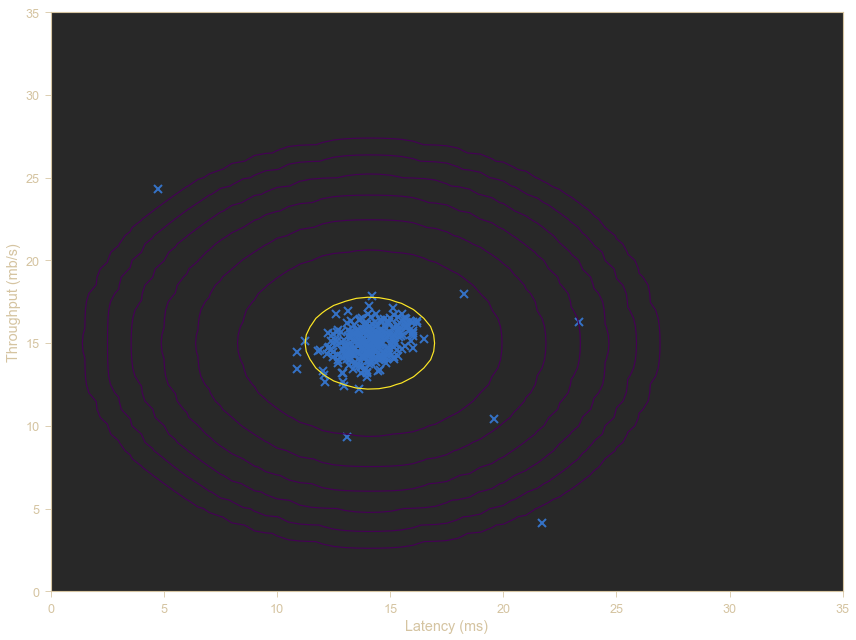

In [22]:
#  Estimate my and sigma2
mu, sigma2 = estimateGaussian(X)

#  Returns the density of the multivariate normal at each data point (row) 
#  of X
p = utils.multivariateGaussian(X, mu, sigma2)

#  Visualize the fit
utils.visualizeFit(X,  mu, sigma2)
pyplot.xlabel('Latency (ms)')
pyplot.ylabel('Throughput (mb/s)')
pyplot.tight_layout()

*You should now submit your solutions.*

In [23]:
grader[1] = estimateGaussian
grader.grade()


Submitting Solutions | Programming Exercise anomaly-detection-and-recommender-systems

Use token from last successful submission (mthwsjc@gmail.com)? (Y/n): 
                                  Part Name |     Score | Feedback
                                  --------- |     ----- | --------
               Estimate Gaussian Parameters |  15 /  15 | Nice work!
                           Select Threshold |   0 /  15 | 
               Collaborative Filtering Cost |   0 /  20 | 
           Collaborative Filtering Gradient |   0 /  30 | 
                           Regularized Cost |   0 /  10 | 
                       Regularized Gradient |   0 /  10 | 
                                  --------------------------------
                                            |  15 / 100 |  



<a id="section2"></a>
### 1.3 Selecting the threshold, $\varepsilon$

Now that you have estimated the Gaussian parameters, you can investigate which examples have a very high probability given this distribution and which examples have a very low probability. The low probability examples are more likely to be the anomalies in our dataset. One way to determine which examples are anomalies is to select a threshold based on a cross validation set. In this part of the exercise, you will implement an algorithm to select the threshold $\varepsilon$ using the $F_1$ score on a cross validation set.


You should now complete the code for the function `selectThreshold`. For this, we will use a cross validation set $\{ (x_{cv}^{(1)}, y_{cv}^{(1)}), \dots, (x_{cv}^{(m_{cv})}, y_{cv}^{(m_{cv})})\}$, where the label $y = 1$ corresponds to an anomalous example, and $y = 0$ corresponds to a normal example. For each cross validation example, we will compute $p\left( x_{cv}^{(i)}\right)$. The vector of all of these probabilities $p\left( x_{cv}^{(1)}\right), \dots, p\left( x_{cv}^{(m_{cv})}\right)$ is passed to `selectThreshold` in the vector `pval`. The corresponding labels $y_{cv}^{(1)} , \dots , y_{cv}^{(m_{cv})}$ are passed to the same function in the vector `yval`.

The function `selectThreshold` should return two values; the first is the selected threshold $\varepsilon$. If an example $x$ has a low probability $p(x) < \varepsilon$, then it is considered to be an anomaly. The function should also return the $F_1$ score, which tells you how well you are doing on finding the ground truth
anomalies given a certain threshold. For many different values of $\varepsilon$, you will compute the resulting $F_1$ score by computing how many examples the current threshold classifies correctly and incorrectly.

The $F_1$ score is computed using precision ($prec$) and recall ($rec$):

$$ F_1 = \frac{2 \cdot prec \cdot rec}{prec + rec}, $$

You compute precision and recall by: 

$$ prec = \frac{tp}{tp + fp}  $$ 

$$ rec = \frac{tp}{tp + fn} $$

where: 

- $tp$ is the number of true positives: the ground truth label says it’s an anomaly and our algorithm correctly classified it as an anomaly.

-  $fp$ is the number of false positives: the ground truth label says it’s not an anomaly, but our algorithm incorrectly classified it as an anomaly.
- $fn$ is the number of false negatives: the ground truth label says it’s an anomaly, but our algorithm incorrectly classified it as not being anomalous.

In the provided code `selectThreshold`, there is already a loop that will try many different values of $\varepsilon$ and select the best $\varepsilon$ based on the $F_1$ score. You should now complete the code in `selectThreshold`. You can implement the computation of the $F_1$ score using a for-loop over all the cross
validation examples (to compute the values $tp$, $fp$, $fn$). You should see a value for `epsilon` of about 8.99e-05.

<div class="alert alert-block alert-warning">
**Implementation Note:** In order to compute $tp$, $fp$ and $fn$, you may be able to use a vectorized implementation rather than loop over all the examples. This can be implemented by numpy's equality test
between a vector and a single number. If you have several binary values in an n-dimensional binary vector $v \in \{0, 1\}^n$, you can find out how many values in this vector are 0 by using: np.sum(v == 0). You can also
apply a logical and operator to such binary vectors. For instance, let `cvPredictions` be a binary vector of  size equal to the number of cross validation set, where the $i^{th}$ element is 1 if your algorithm considers
$x_{cv}^{(i)}$ an anomaly, and 0 otherwise. You can then, for example, compute the number of false positives using: `fp = np.sum((cvPredictions == 1) & (yval == 0))`.
</div>
<a id="selectThreshold"></a>

In [ ]:
def selectThreshold(yval, pval):
    """
    Find the best threshold (epsilon) to use for selecting outliers based
    on the results from a validation set and the ground truth.
    
    Parameters
    ----------
    yval : array_like
        The validation dataset of shape (m x n) where m is the number 
        of examples an n is the number of dimensions(features).
    
    pval : array_like
        The ground truth labels of shape (m, ).
    
    Returns
    -------
    bestEpsilon : array_like
        A vector of shape (n,) corresponding to the threshold value.
    
    bestF1 : float
        The value for the best F1 score.
    
    Instructions
    ------------
    Compute the F1 score of choosing epsilon as the threshold and place the
    value in F1. The code at the end of the loop will compare the
    F1 score for this choice of epsilon and set it to be the best epsilon if
    it is better than the current choice of epsilon.
    
    Notes
    -----
    You can use predictions = (pval < epsilon) to get a binary vector
    of 0's and 1's of the outlier predictions
    """
    bestEpsilon = 0
    bestF1 = 0
    F1 = 0
   
    for epsilon in np.linspace(1.01*min(pval), max(pval), 1000):
        # ====================== YOUR CODE HERE =======================

        
        

        # =============================================================
        if F1 > bestF1:
            bestF1 = F1
            bestEpsilon = epsilon

    return bestEpsilon, bestF1

Once you have completed the code in `selectThreshold`, the next cell will run your anomaly detection code and circle the anomalies in the plot.

In [ ]:
pval = utils.multivariateGaussian(Xval, mu, sigma2)

epsilon, F1 = selectThreshold(yval, pval)
print('Best epsilon found using cross-validation: %.2e' % epsilon)
print('Best F1 on Cross Validation Set:  %f' % F1)
print('   (you should see a value epsilon of about 8.99e-05)')
print('   (you should see a Best F1 value of  0.875000)')

#  Find the outliers in the training set and plot the
outliers = p < epsilon

#  Visualize the fit
utils.visualizeFit(X,  mu, sigma2)
pyplot.xlabel('Latency (ms)')
pyplot.ylabel('Throughput (mb/s)')
pyplot.tight_layout()

#  Draw a red circle around those outliers
pyplot.plot(X[outliers, 0], X[outliers, 1], 'ro', ms=10, mfc='None', mew=2)
pass

*You should now submit your solutions.*

In [ ]:
grader[2] = selectThreshold
grader.grade()

### 1.4 High dimensional dataset

The next cell will run the anomaly detection algorithm you implemented on a more realistic and much harder dataset. In this dataset, each example is described by 11 features, capturing many more properties of your compute servers, but only some features indicate whether a point is an outlier. The script will use your code to estimate the Gaussian parameters ($\mu_i$ and $\sigma_i^2$), evaluate the probabilities for both the training data `X` from which you estimated the Gaussian parameters, and do so for the the cross-validation set `Xval`. Finally, it will use `selectThreshold` to find the best threshold $\varepsilon$. You should see a value epsilon of about 1.38e-18, and 117 anomalies found.

In [ ]:
#  Loads the second dataset. You should now have the
#  variables X, Xval, yval in your environment
data = loadmat(os.path.join('Data', 'ex8data2.mat'))
X, Xval, yval = data['X'], data['Xval'], data['yval'][:, 0]

# Apply the same steps to the larger dataset
mu, sigma2 = estimateGaussian(X)

#  Training set 
p = utils.multivariateGaussian(X, mu, sigma2)

#  Cross-validation set
pval = utils.multivariateGaussian(Xval, mu, sigma2)

#  Find the best threshold
epsilon, F1 = selectThreshold(yval, pval)

print('Best epsilon found using cross-validation: %.2e' % epsilon)
print('Best F1 on Cross Validation Set          : %f\n' % F1)
print('  (you should see a value epsilon of about 1.38e-18)')
print('   (you should see a Best F1 value of      0.615385)')
print('\n# Outliers found: %d' % np.sum(p < epsilon))

## 2 Recommender Systems

In this part of the exercise, you will implement the collaborative filtering learning algorithm and apply it to a dataset of movie ratings ([MovieLens 100k Dataset](https://grouplens.org/datasets/movielens/) from GroupLens Research). This dataset consists of ratings on a scale of 1 to 5. The dataset has $n_u = 943$ users, and $n_m = 1682$ movies. 

In the next parts of this exercise, you will implement the function `cofiCostFunc` that computes the collaborative filtering objective function and gradient. After implementing the cost function and gradient, you will use `scipy.optimize.minimize` to learn the parameters for collaborative filtering.

### 2.1 Movie ratings dataset

The next cell will load the dataset `ex8_movies.mat`, providing the variables `Y` and `R`.
The matrix `Y` (a `num_movies` $\times$ `num_users` matrix) stores the ratings $y^{(i,j)}$ (from 1 to 5). The matrix `R` is an binary-valued indicator matrix, where $R(i, j) = 1$ if user $j$ gave a rating to movie $i$, and $R(i, j) = 0$ otherwise. The objective of collaborative filtering is to predict movie ratings for the movies that users have not yet rated, that is, the entries with $R(i, j) = 0$. This will allow us to recommend the movies with the highest predicted ratings to the user.

To help you understand the matrix `Y`, the following cell will compute the average movie rating for the first movie (Toy Story) and print its average rating.

In [ ]:
# Load data
data = loadmat(os.path.join('Data', 'ex8_movies.mat'))
Y, R = data['Y'], data['R']

# Y is a 1682x943 matrix, containing ratings (1-5) of 
# 1682 movies on 943 users

# R is a 1682x943 matrix, where R(i,j) = 1 
# if and only if user j gave a rating to movie i

# From the matrix, we can compute statistics like average rating.
print('Average rating for movie 1 (Toy Story): %f / 5' %
      np.mean(Y[0, R[0, :]]))

# We can "visualize" the ratings matrix by plotting it with imshow
pyplot.figure(figsize=(8, 8))
pyplot.imshow(Y)
pyplot.ylabel('Movies')
pyplot.xlabel('Users')
pyplot.grid(False)

Throughout this part of the exercise, you will also be working with the matrices, `X` and `Theta`:

$$ \text{X} = 
\begin{bmatrix}
- \left(x^{(1)}\right)^T - \\
- \left(x^{(2)}\right)^T - \\
\vdots \\
- \left(x^{(n_m)}\right)^T - \\
\end{bmatrix}, \quad
\text{Theta} = 
\begin{bmatrix}
- \left(\theta^{(1)}\right)^T - \\
- \left(\theta^{(2)}\right)^T - \\
\vdots \\
- \left(\theta^{(n_u)}\right)^T - \\
\end{bmatrix}.
$$

The $i^{th}$ row of `X` corresponds to the feature vector $x^{(i)}$ for the $i^{th}$ movie, and the $j^{th}$ row of `Theta` corresponds to one parameter vector $\theta^{(j)}$, for the $j^{th}$ user. Both $x^{(i)}$ and $\theta^{(j)}$ are n-dimensional vectors. For the purposes of this exercise, you will use $n = 100$, and therefore, $x^{(i)} \in \mathbb{R}^{100}$ and $\theta^{(j)} \in \mathbb{R}^{100}$. Correspondingly, `X` is a $n_m \times 100$ matrix and `Theta` is a $n_u \times 100$ matrix.

<a id="section3"></a>
### 2.2 Collaborative filtering learning algorithm

Now, you will start implementing the collaborative filtering learning algorithm. You will start by implementing the cost function (without regularization).

The collaborative filtering algorithm in the setting of movie recommendations considers a set of n-dimensional parameter vectors $x^{(1)}, \dots, x^{(n_m)}$ and $\theta^{(1)} , \dots, \theta^{(n_u)}$, where the model predicts the rating for movie $i$ by user $j$ as $y^{(i,j)} = \left( \theta^{(j)} \right)^T x^{(i)}$. Given a dataset that consists of a set of ratings produced by some users on some movies, you wish to learn the parameter vectors $x^{(1)}, \dots, x^{(n_m)}, \theta^{(1)}, \dots, \theta^{(n_u)}$ that produce the best fit (minimizes the squared error).

You will complete the code in `cofiCostFunc` to compute the cost function and gradient for collaborative filtering. Note that the parameters to the function (i.e., the values that you are trying to learn) are `X` and `Theta`. In order to use an off-the-shelf minimizer such as `scipy`'s `minimize` function, the cost function has been set up to unroll the parameters into a single vector called `params`. You had previously used the same vector unrolling method in the neural networks programming exercise.

#### 2.2.1 Collaborative filtering cost function

The collaborative filtering cost function (without regularization) is given by

$$
J(x^{(1)}, \dots, x^{(n_m)}, \theta^{(1)}, \dots,\theta^{(n_u)}) = \frac{1}{2} \sum_{(i,j):r(i,j)=1} \left( \left(\theta^{(j)}\right)^T x^{(i)} - y^{(i,j)} \right)^2
$$

You should now modify the function `cofiCostFunc` to return this cost in the variable `J`. Note that you should be accumulating the cost for user $j$ and movie $i$ only if `R[i,j] = 1`.

<div class="alert alert-block alert-warning">
**Implementation Note**: We strongly encourage you to use a vectorized implementation to compute $J$, since it will later by called many times by `scipy`'s optimization package. As usual, it might be easiest to first write a non-vectorized implementation (to make sure you have the right answer), and the modify it to become a vectorized implementation (checking that the vectorization steps do not change your algorithm’s output). To come up with a vectorized implementation, the following tip might be helpful: You can use the $R$ matrix to set selected entries to 0. For example, `R * M` will do an element-wise multiplication between `M`
and `R`; since `R` only has elements with values either 0 or 1, this has the effect of setting the elements of M to 0 only when the corresponding value in R is 0. Hence, `np.sum( R * M)` is the sum of all the elements of `M` for which the corresponding element in `R` equals 1.
</div>

<a id="cofiCostFunc"></a>

In [ ]:
def cofiCostFunc(params, Y, R, num_users, num_movies,
                      num_features, lambda_=0.0):
    """
    Collaborative filtering cost function.
    
    Parameters
    ----------
    params : array_like
        The parameters which will be optimized. This is a one
        dimensional vector of shape (num_movies x num_users, 1). It is the 
        concatenation of the feature vectors X and parameters Theta.
    
    Y : array_like
        A matrix of shape (num_movies x num_users) of user ratings of movies.
    
    R : array_like
        A (num_movies x num_users) matrix, where R[i, j] = 1 if the 
        i-th movie was rated by the j-th user.
    
    num_users : int
        Total number of users.
    
    num_movies : int
        Total number of movies.
    
    num_features : int
        Number of features to learn.
    
    lambda_ : float, optional
        The regularization coefficient.
    
    Returns
    -------
    J : float
        The value of the cost function at the given params.
    
    grad : array_like
        The gradient vector of the cost function at the given params.
        grad has a shape (num_movies x num_users, 1)
    
    Instructions
    ------------
    Compute the cost function and gradient for collaborative filtering.
    Concretely, you should first implement the cost function (without
    regularization) and make sure it is matches our costs. After that,
    you should implement thegradient and use the checkCostFunction routine 
    to check that the gradient is correct. Finally, you should implement
    regularization.
    
    Notes
    -----
    - The input params will be unraveled into the two matrices:
        X : (num_movies  x num_features) matrix of movie features
        Theta : (num_users  x num_features) matrix of user features

    - You should set the following variables correctly:

        X_grad : (num_movies x num_features) matrix, containing the 
                 partial derivatives w.r.t. to each element of X
        Theta_grad : (num_users x num_features) matrix, containing the 
                     partial derivatives w.r.t. to each element of Theta

    - The returned gradient will be the concatenation of the raveled 
      gradients X_grad and Theta_grad.
    """
    # Unfold the U and W matrices from params
    X = params[:num_movies*num_features].reshape(num_movies, num_features)
    Theta = params[num_movies*num_features:].reshape(num_users, num_features)

    # You need to return the following values correctly
    J = 0
    X_grad = np.zeros(X.shape)
    Theta_grad = np.zeros(Theta.shape)

    # ====================== YOUR CODE HERE ======================

    
    
    # =============================================================
    
    grad = np.concatenate([X_grad.ravel(), Theta_grad.ravel()])
    return J, grad

After you have completed the function, the next cell will run your cost function. To help you debug your cost function, we have included set of weights that we trained on that.  You should expect to see an output of 22.22.

In [ ]:
#  Load pre-trained weights (X, Theta, num_users, num_movies, num_features)
data = loadmat(os.path.join('Data', 'ex8_movieParams.mat'))
X, Theta, num_users, num_movies, num_features = data['X'],\
        data['Theta'], data['num_users'], data['num_movies'], data['num_features']

#  Reduce the data set size so that this runs faster
num_users = 4
num_movies = 5
num_features = 3

X = X[:num_movies, :num_features]
Theta = Theta[:num_users, :num_features]
Y = Y[:num_movies, 0:num_users]
R = R[:num_movies, 0:num_users]

#  Evaluate cost function
J, _ = cofiCostFunc(np.concatenate([X.ravel(), Theta.ravel()]),
                    Y, R, num_users, num_movies, num_features)
           
print('Cost at loaded parameters:  %.2f \n(this value should be about 22.22)' % J)

*You should now submit your solutions.*

In [ ]:
grader[3] = cofiCostFunc
grader.grade()

<a id="section4"></a>
#### 2.2.2 Collaborative filtering gradient

Now you should implement the gradient (without regularization). Specifically, you should complete the code in `cofiCostFunc` to return the variables `X_grad` and `Theta_grad`. Note that `X_grad` should be a matrix of the same size as `X` and similarly, `Theta_grad` is a matrix of the same size as
`Theta`. The gradients of the cost function is given by:

$$ \frac{\partial J}{\partial x_k^{(i)}} = \sum_{j:r(i,j)=1} \left( \left(\theta^{(j)}\right)^T x^{(i)} - y^{(i,j)} \right) \theta_k^{(j)} $$

$$ \frac{\partial J}{\partial \theta_k^{(j)}} = \sum_{i:r(i,j)=1} \left( \left(\theta^{(j)}\right)^T x^{(i)}- y^{(i,j)} \right) x_k^{(j)} $$

Note that the function returns the gradient for both sets of variables by unrolling them into a single vector. After you have completed the code to compute the gradients, the next cell run a gradient check
(available in `utils.checkCostFunction`) to numerically check the implementation of your gradients (this is similar to the numerical check that you used in the neural networks exercise. If your implementation is correct, you should find that the analytical and numerical gradients match up closely.

<div class="alert alert-block alert-warning">
**Implementation Note:** You can get full credit for this assignment without using a vectorized implementation, but your code will run much more slowly (a small number of hours), and so we recommend that you try to vectorize your implementation. To get started, you can implement the gradient with a for-loop over movies
(for computing $\frac{\partial J}{\partial x^{(i)}_k}$) and a for-loop over users (for computing $\frac{\partial J}{\theta_k^{(j)}}$). When you first implement the gradient, you might start with an unvectorized version, by implementing another inner for-loop that computes each element in the summation. After you have completed the gradient computation this way, you should try to vectorize your implementation (vectorize the inner for-loops), so that you are left with only two for-loops (one for looping over movies to compute $\frac{\partial J}{\partial x_k^{(i)}}$ for each movie, and one for looping over users to compute $\frac{\partial J}{\partial \theta_k^{(j)}}$ for each user).
</div>

<div class="alert alert-block alert-warning">
**Implementation Tip:** To perform the vectorization, you might find this helpful: You should come up with a way to compute all the derivatives associated with $x_1^{(i)} , x_2^{(i)}, \dots , x_n^{(i)}$ (i.e., the derivative terms associated with the feature vector $x^{(i)}$) at the same time. Let us define the derivatives for the feature vector of the $i^{th}$ movie as:

$$ \left(X_{\text{grad}} \left(i, :\right)\right)^T = 
\begin{bmatrix}
\frac{\partial J}{\partial x_1^{(i)}} \\
\frac{\partial J}{\partial x_2^{(i)}} \\
\vdots \\
\frac{\partial J}{\partial x_n^{(i)}}
\end{bmatrix} = \quad
\sum_{j:r(i,j)=1} \left( \left( \theta^{(j)} \right)^T x^{(i)} - y^{(i,j)} \right) \theta^{(j)}
$$

To vectorize the above expression, you can start by indexing into `Theta` and `Y` to select only the elements of interests (that is, those with `r[i, j] = 1`). Intuitively, when you consider the features for the $i^{th}$ movie, you only need to be concerned about the users who had given ratings to the movie, and this allows you to remove all the other users from `Theta` and `Y`. <br/><br/>


Concretely, you can set `idx = np.where(R[i, :] == 1)[0]` to be a list of all the users that have rated movie $i$. This will allow you to create the temporary matrices `Theta_temp = Theta[idx, :]` and `Y_temp = Y[i, idx]` that index into `Theta` and `Y` to give you only the set of users which have rated the $i^{th}$ movie. This will allow you to write the derivatives as: <br>

`X_grad[i, :] = np.dot(np.dot(X[i, :], Theta_temp.T) - Y_temp, Theta_temp)`

<br><br>
Note that the vectorized computation above returns a row-vector instead. After you have vectorized the computations of the derivatives with respect to $x^{(i)}$, you should use a similar method to vectorize the derivatives with respect to $θ^{(j)}$ as well.
</div>

[Click here to go back to the function `cofiCostFunc` to update it](#cofiCostFunc). 

<font color="red"> Do not forget to re-execute the cell containg the function `cofiCostFunc` so that it is updated with your implementation of the gradient computation.</font>

In [ ]:
#  Check gradients by running checkcostFunction
utils.checkCostFunction(cofiCostFunc)

*You should now submit your solutions*

In [ ]:
grader[4] = cofiCostFunc
grader.grade()

<a id="section5"></a>
#### 2.2.3 Regularized cost function

The cost function for collaborative filtering with regularization is given by

$$ J(x^{(1)}, \dots, x^{(n_m)}, \theta^{(1)}, \dots, \theta^{(n_u)}) = \frac{1}{2} \sum_{(i,j):r(i,j)=1} \left( \left( \theta^{(j)} \right)^T x^{(i)} - y^{(i,j)} \right)^2 + \left( \frac{\lambda}{2} \sum_{j=1}^{n_u} \sum_{k=1}^{n} \left( \theta_k^{(j)} \right)^2  \right) + \left( \frac{\lambda}{2} \sum_{i=1}^{n_m} \sum_{k=1}^n \left(x_k^{(i)} \right)^2 \right) $$

You should now add regularization to your original computations of the cost function, $J$. After you are done, the next cell will run your regularized cost function, and you should expect to see a cost of about 31.34.

[Click here to go back to the function `cofiCostFunc` to update it](#cofiCostFunc)
<font color="red"> Do not forget to re-execute the cell containing the function `cofiCostFunc` so that it is updated with your implementation of regularized cost function.</font>

In [ ]:
#  Evaluate cost function
J, _ = cofiCostFunc(np.concatenate([X.ravel(), Theta.ravel()]),
                    Y, R, num_users, num_movies, num_features, 1.5)
           
print('Cost at loaded parameters (lambda = 1.5): %.2f' % J)
print('              (this value should be about 31.34)')

*You should now submit your solutions.*

In [ ]:
grader[5] = cofiCostFunc
grader.grade()

<a id="section6"></a>
#### 2.2.4 Regularized gradient

Now that you have implemented the regularized cost function, you should proceed to implement regularization for the gradient. You should add to your implementation in `cofiCostFunc` to return the regularized gradient
by adding the contributions from the regularization terms. Note that the gradients for the regularized cost function is given by:

$$ \frac{\partial J}{\partial x_k^{(i)}} = \sum_{j:r(i,j)=1} \left( \left(\theta^{(j)}\right)^T x^{(i)} - y^{(i,j)} \right) \theta_k^{(j)} + \lambda x_k^{(i)} $$

$$ \frac{\partial J}{\partial \theta_k^{(j)}} = \sum_{i:r(i,j)=1} \left( \left(\theta^{(j)}\right)^T x^{(i)}- y^{(i,j)} \right) x_k^{(j)} + \lambda \theta_k^{(j)} $$

This means that you just need to add $\lambda x^{(i)}$ to the `X_grad[i,:]` variable described earlier, and add $\lambda \theta^{(j)}$ to the `Theta_grad[j, :]` variable described earlier.

[Click here to go back to the function `cofiCostFunc` to update it](#cofiCostFunc)
<font color="red"> Do not forget to re-execute the cell containing the function `cofiCostFunc` so that it is updated with your implementation of the gradient for the regularized cost function.</font>

After you have completed the code to compute the gradients, the following cell will run another gradient check (`utils.checkCostFunction`) to numerically check the implementation of your gradients.

In [ ]:
#  Check gradients by running checkCostFunction
utils.checkCostFunction(cofiCostFunc, 1.5)

*You should now submit your solutions.*

In [ ]:
grader[6] = cofiCostFunc
grader.grade()

### 2.3 Learning movie recommendations 

After you have finished implementing the collaborative filtering cost function and gradient, you can now start training your algorithm to make movie recommendations for yourself. In the next cell, you can enter your own movie preferences, so that later when the algorithm runs, you can get your own movie recommendations! We have filled out some values according to our own preferences, but you should change this according to your own tastes. The list of all movies and their number in the dataset can be found listed in the file `Data/movie_idx.txt`.

In [ ]:
#  Before we will train the collaborative filtering model, we will first
#  add ratings that correspond to a new user that we just observed. This
#  part of the code will also allow you to put in your own ratings for the
#  movies in our dataset!
movieList = utils.loadMovieList()
n_m = len(movieList)

#  Initialize my ratings
my_ratings = np.zeros(n_m)

# Check the file movie_idx.txt for id of each movie in our dataset
# For example, Toy Story (1995) has ID 1, so to rate it "4", you can set
# Note that the index here is ID-1, since we start index from 0.
my_ratings[0] = 4

# Or suppose did not enjoy Silence of the Lambs (1991), you can set
my_ratings[97] = 2

# We have selected a few movies we liked / did not like and the ratings we
# gave are as follows:
my_ratings[6] = 3
my_ratings[11]= 5
my_ratings[53] = 4
my_ratings[63] = 5
my_ratings[65] = 3
my_ratings[68] = 5
my_ratings[182] = 4
my_ratings[225] = 5
my_ratings[354] = 5

print('New user ratings:')
print('-----------------')
for i in range(len(my_ratings)):
    if my_ratings[i] > 0:
        print('Rated %d stars: %s' % (my_ratings[i], movieList[i]))

#### 2.3.1 Recommendations

After the additional ratings have been added to the dataset, the script
will proceed to train the collaborative filtering model. This will learn the
parameters X and Theta. To predict the rating of movie i for user j, you need to compute (θ (j) ) T x (i) . The next part of the script computes the ratings for
all the movies and users and displays the movies that it recommends (Figure
4), according to ratings that were entered earlier in the script. Note that
you might obtain a different set of the predictions due to different random
initializations.

In [ ]:
#  Now, you will train the collaborative filtering model on a movie rating 
#  dataset of 1682 movies and 943 users

#  Load data
data = loadmat(os.path.join('Data', 'ex8_movies.mat'))
Y, R = data['Y'], data['R']

#  Y is a 1682x943 matrix, containing ratings (1-5) of 1682 movies by 
#  943 users

#  R is a 1682x943 matrix, where R(i,j) = 1 if and only if user j gave a
#  rating to movie i

#  Add our own ratings to the data matrix
Y = np.hstack([my_ratings[:, None], Y])
R = np.hstack([(my_ratings > 0)[:, None], R])

#  Normalize Ratings
Ynorm, Ymean = utils.normalizeRatings(Y, R)

#  Useful Values
num_movies, num_users = Y.shape
num_features = 10

# Set Initial Parameters (Theta, X)
X = np.random.randn(num_movies, num_features)
Theta = np.random.randn(num_users, num_features)

initial_parameters = np.concatenate([X.ravel(), Theta.ravel()])

# Set options for scipy.optimize.minimize
options = {'maxiter': 100}

# Set Regularization
lambda_ = 10
res = optimize.minimize(lambda x: cofiCostFunc(x, Ynorm, R, num_users,
                                               num_movies, num_features, lambda_),
                        initial_parameters,
                        method='TNC',
                        jac=True,
                        options=options)
theta = res.x

# Unfold the returned theta back into U and W
X = theta[:num_movies*num_features].reshape(num_movies, num_features)
Theta = theta[num_movies*num_features:].reshape(num_users, num_features)

print('Recommender system learning completed.')

After training the model, you can now make recommendations by computing the predictions matrix.

In [ ]:
p = np.dot(X, Theta.T)
my_predictions = p[:, 0] + Ymean

movieList = utils.loadMovieList()

ix = np.argsort(my_predictions)[::-1]

print('Top recommendations for you:')
print('----------------------------')
for i in range(10):
    j = ix[i]
    print('Predicting rating %.1f for movie %s' % (my_predictions[j], movieList[j]))

print('\nOriginal ratings provided:')
print('--------------------------')
for i in range(len(my_ratings)):
    if my_ratings[i] > 0:
        print('Rated %d for %s' % (my_ratings[i], movieList[i]))